# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## User Functions

In [2]:
def plot_1by2 (fig1, fig2, cmap='color', save=False, fname='noname') :
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(fig1, cmap=cmap)
    ax1.set_title('Input Image', fontsize=30)
    ax2.imshow(fig2, cmap=cmap)
    ax2.set_title('Processed Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if save == True :
        plt.savefig(fname)

## Compute the camera calibration matrix and distortion coefficients

In [3]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
mtx = []
dist = []

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the derived information
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./dist_pickle.p", "wb" ) )

In [4]:
def undistort (img, mtx, dist) :
    img_size = (img.shape[1], img.shape[0])    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst

dist_file = './dist_pickle.p'
with open(dist_file, mode='rb') as f:
    dist_pickle = pickle.load(f)
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]    
        
list_img = os.listdir('./test_images/')

for idx in range(len(list_img)) :
    img = cv2.imread('./test_images/%s' % list_img[idx])    
    undist = undistort(img, mtx, dist)
    write_name = './output_images/'+list_img[idx]
    cv2.imwrite(write_name, undist)

#### Result of undistortion

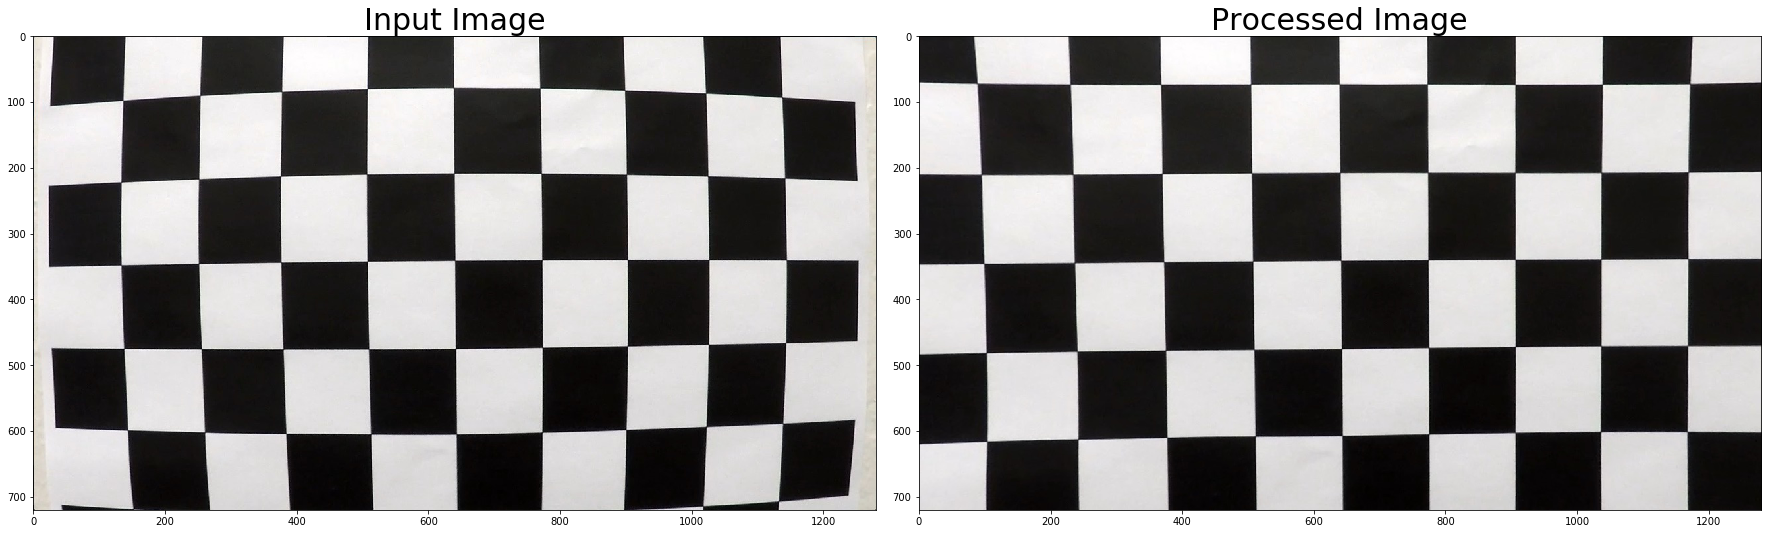

In [5]:
dist_file = './dist_pickle.p'
with open(dist_file, mode='rb') as f:
    dist_pickle = pickle.load(f)
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]    

distorted = mpimg.imread('./camera_cal/calibration1.jpg')
fname = './figures/calibration.png'
plot_1by2(distorted, undistort(distorted, mtx, dist), None, True, fname)

## Generate Sample Images from Video
1) Generate a set of images  

In [6]:
cap_clip = VideoFileClip("./project_video.mp4")

## Generate 50 samples with the rate of 1 image/second during
i = 0
while i < 50 :
    frame = cap_clip.get_frame(i)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = undistort(frame, mtx, dist)
    cv2.imwrite("./samples/%s.jpg"%(str(i)), frame)
    i += 1 

2) Capture an image at specific time

In [7]:
def capture(t) :
    cap_clip = VideoFileClip("./project_video.mp4")
    frame = cap_clip.get_frame(t)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = undistort(frame, mtx, dist)
    retval = cv2.imwrite("./samples/%s.jpg"%(str(t)), frame)
    
    return retval
    
capture(39.4)

True

## Finding edges
1) Binarize an image by setting threshold values for gradient and some color channels to find edges    
2) Remove the points which are out of setted region  

Functions for binarization of input images

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,  ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,  ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelx = np.absolute(sobelx)
    sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction_grad = np.arctan2(sobely, sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction_grad)
    binary_output[(direction_grad >= thresh[0]) & (direction_grad <= thresh[1])] = 1 
    # 6) Return this mask as your binary_output image
    return binary_output

Set region of interest in images

In [9]:
def mask_image (img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

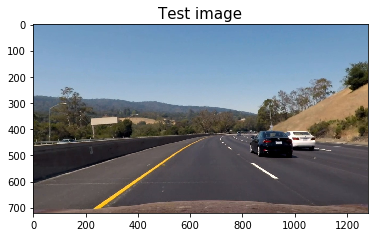

In [10]:
image = mpimg.imread('./samples/35.jpg')
fname = './figures/test_image.png'
plt.imshow(image)
plt.title('Test image', fontsize=15)
plt.savefig(fname)

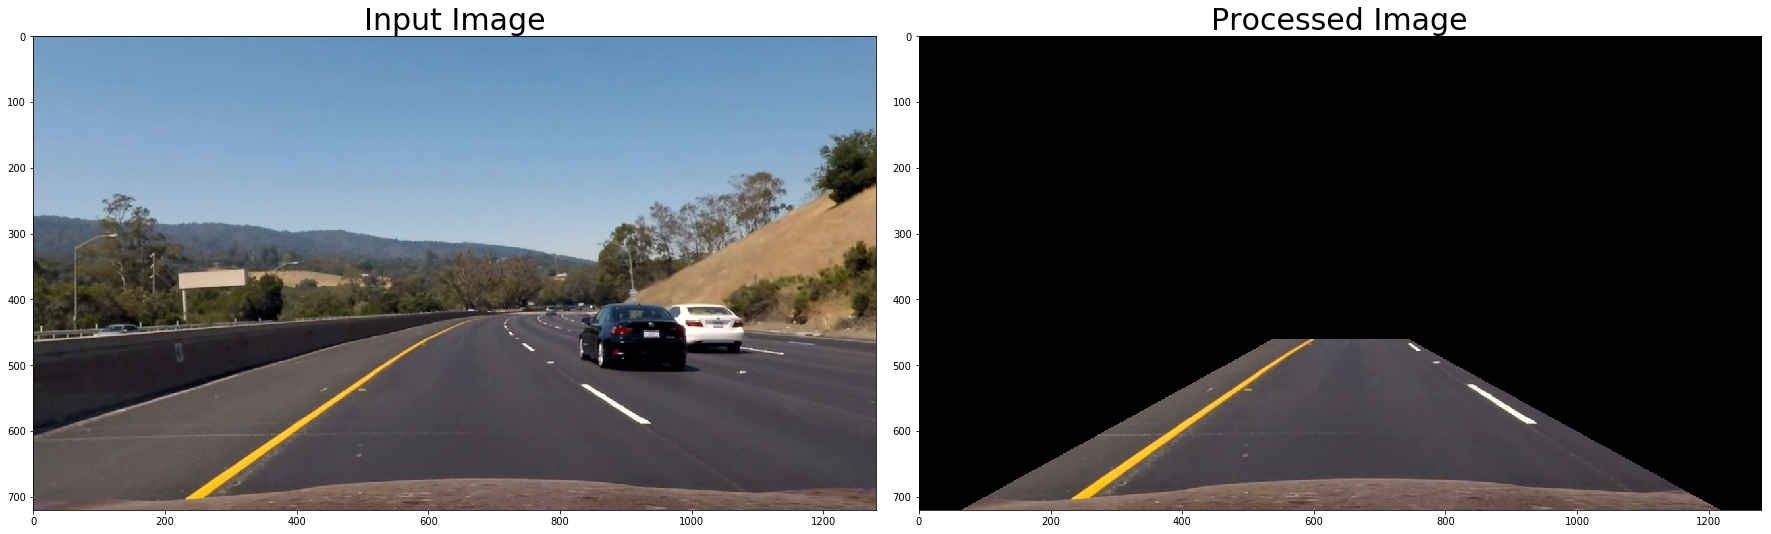

In [11]:
fname = './figures/masked.png'
w = image.shape[1]
h = image.shape[0]

vertex_LB = [w*0.05, h     ]  # Left-Bottom
vertex_LT = [w*0.42, h*0.64]  # Left-Top
vertex_RT = [w*0.58, h*0.64]  # Right-Top
vertex_RB = [w*0.95, h     ]  # Right-Bottom
vertices = np.array([[vertex_LB, vertex_LT, vertex_RT, vertex_RB]], dtype=np.int32)    

plot_1by2(image, mask_image(image, vertices), cmap=None, save=True, fname=fname)

In [12]:
def detect_edge (image, debug = False) :    
    '''
    1. Get binary image using 
      - S-channel
      - L-channel
      - X-gradient & Y-gradient
      
    2. Set Region of Interest
    '''
    
    width = image.shape[1]   
    height = image.shape[0]
    
    # Set points for setting ROI
    vertex_LB = [width*0.05, height     ]  # Left-Bottom
    vertex_LT = [width*0.42, height*0.64]  # Left-Top
    vertex_RT = [width*0.58, height*0.64]  # Right-Top
    vertex_RB = [width*0.95, height     ]  # Right-Bottom
    vertices = np.array([[vertex_LB, vertex_LT, vertex_RT, vertex_RB]], dtype=np.int32)
    
    # Get S-channel and L-channel
    l_ch = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)[:,:,1]
    s_ch = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)[:,:,2]
    c_binary = np.zeros_like(s_ch)    
    c_binary[(s_ch >= 120) & (s_ch <=255) & (l_ch >= 40) & (s_ch <=255)] = 1    
    
    # Choose a Sobel kernel size
    #ksize = 15 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(20, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(20, 255))
    grad = np.zeros_like(gradx)
    grad[(gradx == 1) & (grady == 1)] = 1    
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(40, 255))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.55))

    combined = np.zeros_like(dir_binary)        
    combined[(c_binary == 1) | (grad == 1)] = 1    
    combined = mask_image(combined, vertices)
    
    if debug :    
        return combined, c_binary, grad, mag_binary, dir_binary
    else :
        return combined

In [13]:
image = mpimg.imread('./samples/35.jpg')
combined, c_binary, grad, mag_binary, dir_binary = detect_edge(image, True)

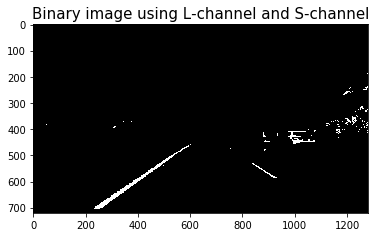

In [14]:
plt.imshow(c_binary, cmap='gray')
plt.title('Binary image using L-channel and S-channel', fontsize=15)
plt.savefig('./figures/c_binary.png')

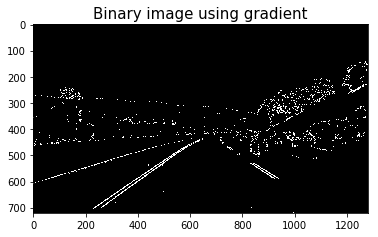

In [15]:
plt.imshow(grad, cmap='gray')
plt.title('Binary image using gradient', fontsize=15)
plt.savefig('./figures/grad.png')

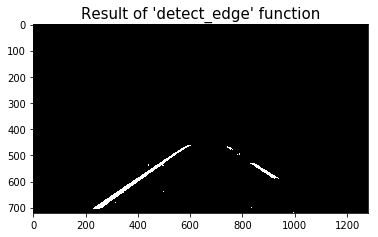

In [16]:
plt.imshow(combined, cmap='gray')
plt.title('Result of \'detect_edge\' function', fontsize=15)
plt.savefig('./figures/combined.png')

## Perspective Transform

In [17]:
def warp_image (image, src, inv = False) :
    shape = image.shape
    
    offset = 100    
    dst_LB = [src[0][0]+offset, shape[0]]  # Left-Bottom
    dst_LT = [src[0][0]+offset, 0       ]  # Left-Top
    dst_RT = [src[3][0]-offset, 0       ]  # Right-Top
    dst_RB = [src[3][0]-offset, shape[0]]  # Right-Bottom
    
    dst = np.float32([dst_LB, dst_LT, dst_RT, dst_RB])
    if inv == True :
        M = cv2.getPerspectiveTransform(dst, src)
    else :
        M = cv2.getPerspectiveTransform(src, dst) 
    warped = cv2.warpPerspective(image, M, (shape[1],shape[0]), flags=cv2.INTER_LINEAR)        
    
    return warped

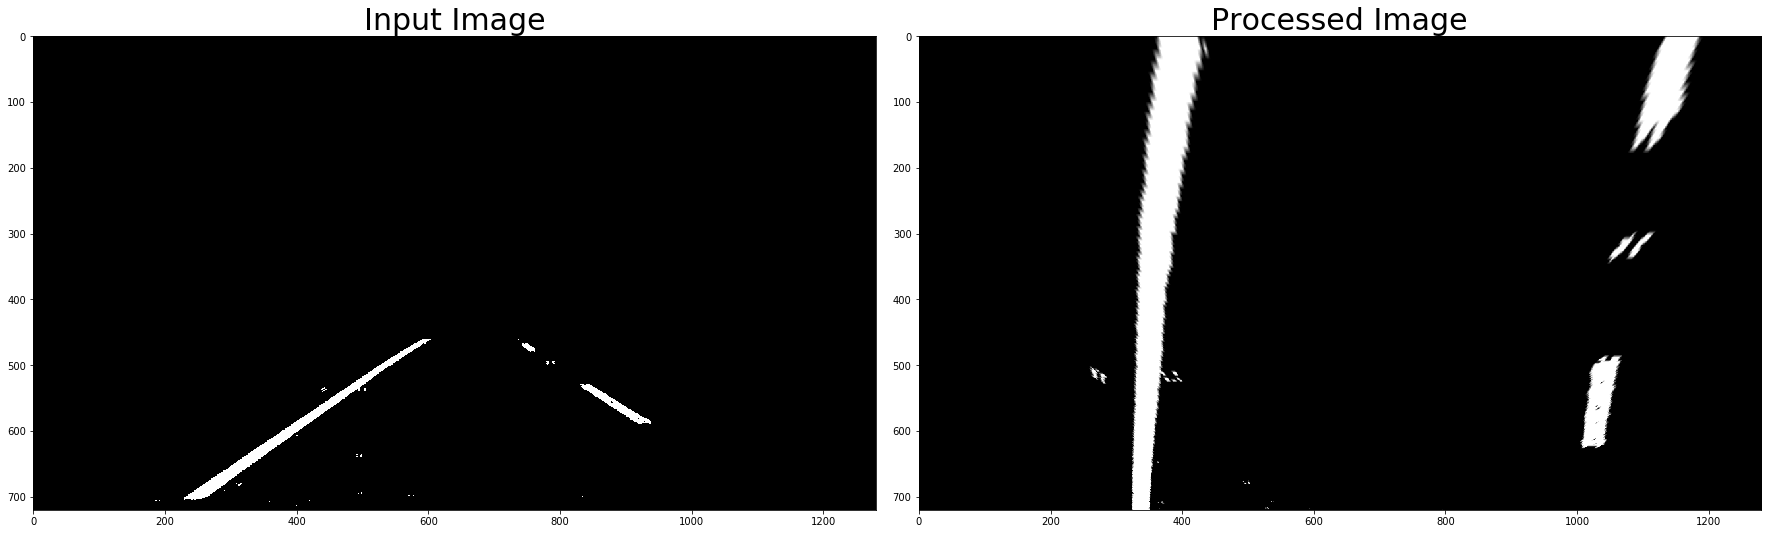

In [18]:
warp_in = combined

h, w = warp_in.shape[0], warp_in.shape[1]

src_LB = [200    , 700   ]  # Left-Bottom
src_LT = [w*0.44 , h*0.65]  # Left-Top
src_RT = [w*0.557, h*0.65]  # Right-Top
src_RB = [1100   , 700   ]  # Right-Bottom
src = np.float32([src_LB, src_LT, src_RT, src_RB])

warped = warp_image(warp_in, src)
plot_1by2(warp_in, warped, cmap='gray', save=True, fname='./figures/warped.png')

## Sliding Windows and Fit a Polynomial
 Sliding windows find the indices of lane lines from binarized image. Those indices is used for fitting the lines to 2nd order polynomials.

In [19]:
def find_lines (binary_image) :
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_image[int(binary_image.shape[0]/4):,:], axis=0)    
    histogram = np.sum(binary_image[int(binary_image.shape[0]/2):binary_image.shape[0],:], axis=0)    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint    
    
    #### Parameters for window ####
    nwindows = 6  # Choose the number of sliding windows
    margin = 80  # Set the width of the windows +/- margin
    minpix = 50   # Set minimum number of pixels found to recenter window
    
    # Set height of windows
    window_height = np.int(binary_image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_image.shape[0] - (window+1)*window_height
        win_y_high = binary_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]     
    
    return leftx, lefty, rightx, righty

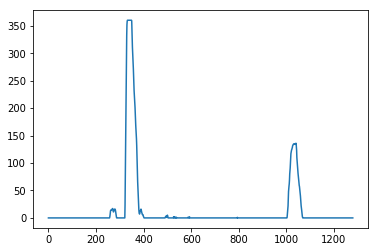

In [20]:
binary_warped = np.zeros_like(warped, dtype=np.uint8)
binary_warped[(warped != 0)] = 1
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)    
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
plt.plot(histogram)
plt.savefig('./figures/histogram.png')

If there are the coefficients found from the last frame, we don't have to find the lines from the scratch.

In [21]:
def find_lines_after_fit (binary_image, left_fit, right_fit) :
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

### Test 'find_lines' function

In [22]:
leftx, lefty, rightx, righty = find_lines(warped)

# Fit a second order polynomial in unit of pixel
left_fit_pix = np.polyfit(lefty, leftx, 2)
right_fit_pix = np.polyfit(righty, rightx, 2)
    
# Fit a second order polynomial in unit of meter
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/800 # meters per pixel in x dimension
left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

print('Coefficients for Left  : ', left_fit_pix)
print('Coefficients for Right : ', right_fit_pix)

mean_fit = (left_fit_pix + right_fit_pix) / 2
mean_fit_m = (left_fit_m + right_fit_m) / 2

Coefficients for Left  :  [  9.96232365e-05  -1.56249919e-01   3.98560630e+02]
Coefficients for Right :  [  1.47754926e-04  -3.04092713e-01   1.15595175e+03]


R of Left Curvature  :  1883.98088298
R of Right Curvature :  1270.4605608
Averaged R of Curvature : 1517.49189108
Center of Camera : 640.0
Center of Lane : 675.7
from_center : -0.17 m


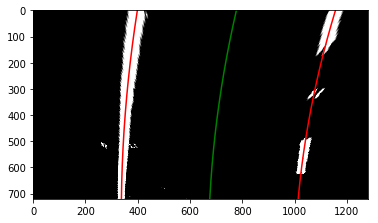

In [23]:
# Generate x and y values for plotting
yvals = np.linspace(0, warped.shape[0]-1, warped.shape[0])
mean_fitx = mean_fit[0]*yvals**2 + mean_fit[1]*yvals + mean_fit[2]
left_fitx = left_fit_pix[0]*yvals**2 + left_fit_pix[1]*yvals + left_fit_pix[2]
right_fitx = right_fit_pix[0]*yvals**2 + right_fit_pix[1]*yvals + right_fit_pix[2]

y_eval = np.max(yvals)*ym_per_pix
left_curverad = ((1 + (2*left_fit_m[0]*y_eval + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
right_curverad = ((1 + (2*right_fit_m[0]*y_eval + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
print('R of Left Curvature  : ', left_curverad)
print('R of Right Curvature : ', right_curverad)

y_eval = np.max(yvals)*ym_per_pix
mean_curverad = ((1 + (2*mean_fit_m[0]*y_eval + mean_fit_m[1])**2)**1.5) / np.absolute(2*mean_fit_m[0])
from_center = ((warped.shape[1]/2) - ((right_fitx[-1]+left_fitx[-1])/2)) * xm_per_pix

print('Averaged R of Curvature :', mean_curverad)
print('Center of Camera : %.1f' % float(warped.shape[1]/2))
print('Center of Lane : %.1f'% (((right_fitx[-1]+left_fitx[-1])/2)))
print('from_center : %.2f m' % from_center)

plt.imshow(warped, cmap='gray')
plt.plot(left_fitx, yvals, color='red')
plt.plot(right_fitx, yvals, color='red')
plt.plot((left_fitx+right_fitx)/2, yvals, color='green')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0], 0)
plt.savefig('./figures/fitted_lines.png')

### Visualization

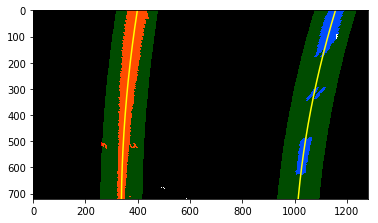

In [24]:
binary_warped = np.zeros_like(warped, dtype=np.uint8)
binary_warped[(warped != 0)] = 1
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_ = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 8
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('./figures/find_lane_line.png')

### Test 'find_lines_after_fit'

(720, 0)

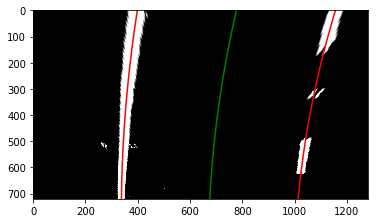

In [140]:
leftx, lefty, rightx, righty = find_lines_after_fit(warped, left_fit_pix, right_fit_pix)
left_fit_pix = np.polyfit(lefty, leftx, 2)
right_fit_pix = np.polyfit(righty, rightx, 2)

yvals = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = left_fit_pix[0]*yvals**2 + left_fit_pix[1]*yvals + left_fit_pix[2]
right_fitx = right_fit_pix[0]*yvals**2 + right_fit_pix[1]*yvals + right_fit_pix[2]

out_img = np.dstack((warped, warped, warped))*255
plt.imshow(warped, cmap='gray')
plt.plot(left_fitx, yvals, color='red')
plt.plot(right_fitx, yvals, color='red')
plt.plot(mean_fitx, yvals, color='green')
plt.xlim(0, warped.shape[1])
plt.ylim(warped.shape[0], 0)

## Projection of found lane onto the input image
1) Draw the polygon indicating the lane  
2) Dewarp  
3) Overlapping dewarped image and original image  

In [33]:
def draw_lane (image, src, left_x, right_x, yvals, curv, dist) :
    filled_poly = np.zeros_like(img).astype(np.uint8)

    # Drawing lane
    pts_left = np.array([np.transpose(np.vstack([left_x, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(filled_poly, np.int_([pts]), (0, 255, 0))
    
    # Drawing left lane line
    pts_left_d = np.array([np.transpose(np.vstack([left_x-20, yvals]))])
    pts_left_line = np.hstack((pts_left_d, pts_left))
    cv2.fillPoly(filled_poly, np.int_([pts_left_line]), (255, 0, 0)) # temp 
    
    # Drawing right lane line
    pts_right_d = np.array([np.transpose(np.vstack([right_x+20, yvals]))])
    pts_right_line = np.hstack((pts_right, pts_right_d))
    cv2.fillPoly(filled_poly, np.int_([pts_right_line]), (0, 0, 255)) # temp 
    
    # Dewarping & overlapping
    filled_poly = warp_image(filled_poly, src, inv = True)
    overlapped = cv2.addWeighted(image, 1, filled_poly, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(overlapped, 'Curvature : %.1f m'%(curv), (50,50), font, 1,(255,255,255), 2, cv2.LINE_AA)
    cv2.putText(overlapped, 'Dist. from Center : %.1f m'%(dist), (50,90), font, 1,(255,255,255), 2, cv2.LINE_AA)    
    
    return overlapped

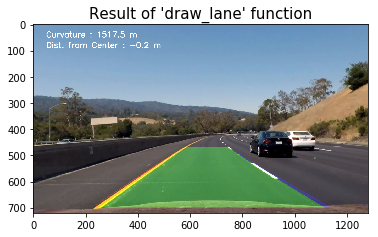

In [34]:
redraw = draw_lane (image, src, left_fitx, right_fitx, yvals, mean_curverad, from_center)
plt.imshow(redraw)
plt.title('Result of \'draw_lane\' function', fontsize=15)
plt.savefig('./figures/detected_lane.png')

## Pipeline for Processing Video
Define a class to receive the characteristics of each line detection

In [35]:
from collections import deque

class Line():
        
    def __init__(self, depth=6):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque(maxlen=depth)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients of the last n fits
        self.recent_fit = deque(maxlen=depth)
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

Define the pipeline in form of function.  
1) Load camera calibration matrix and distortion coefficients  
2) **Undistort**  
3) **Binarize** with some thresholds  
4) **Warp** binarized image to bird-eye view  
5) **Find lane lines** and **fitting** 
6) **Update** the instances  
7) **Calculate** radius of curvature and distance from lane center

In [36]:
def process_image (img) :
    global l_line, r_line
    
    ####################################
    # Pre-calculated Calibration Info.
    ####################################
    dist_file = './dist_pickle.p'
    with open(dist_file, mode='rb') as f:
        dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]    
    
    temp = undistort(img, mtx, dist)
    temp = detect_edge(temp)
    
    ###############################################
    # Define the region to be warped
    ###############################################
    h = img.shape[0]
    w = img.shape[1]
    src_LB = [200   , 700     ]   # Left-Bottom
    src_LT = [w*0.44, h*0.65  ]  # Left-Top
    src_RT = [w*0.557, h*0.65 ]  # Right-Top
    src_RB = [1100  , 700     ]   # Right-Bottom
    src = np.float32([src_LB, src_LT, src_RT, src_RB])
    
    yvals = np.linspace(0, h-1, h) 
    warped = warp_image(temp, src)
        
    if l_line.detected and r_line.detected :
        l_line.allx, l_line.ally, r_line.allx, r_line.ally = find_lines_after_fit (warped, l_line.recent_fit[-1], r_line.recent_fit[-1])
        # If it is failed to find lane lines using last coefficients
        if not all([l_line.allx.shape[0], l_line.ally.shape[0], r_line.allx.shape[0], r_line.ally.shape[0]]) :
            l_line.detected = False
            r_line.detected = False
            overlapped = draw_lane (img, src, l_line.bestx, r_line.bestx, yvals, l_line.radius_of_curvature, l_line.line_base_pos)
            return overlapped            
        l_line.current_fit = np.polyfit(l_line.ally, l_line.allx, 2)
        r_line.current_fit = np.polyfit(r_line.ally, r_line.allx, 2)
        l_line.diffs = l_line.current_fit - l_line.recent_fit[-1]
        r_line.diffs = r_line.current_fit - r_line.recent_fit[-1]
        # Check sanity
        if any(l_line.diffs/l_line.best_fit > 0.1) or any(r_line.diffs/r_line.best_fit > 0.1) :
            l_line.detected = False
            r_line.detected = False
            overlapped = draw_lane (img, src, l_line.bestx, r_line.bestx, yvals, l_line.radius_of_curvature, l_line.line_base_pos)
            return overlapped
    else :
        l_line.allx, l_line.ally, r_line.allx, r_line.ally = find_lines(warped)
        l_line.current_fit = np.polyfit(l_line.ally, l_line.allx, 2)
        r_line.current_fit = np.polyfit(r_line.ally, r_line.allx, 2)
        l_line.detected = True
        r_line.detected = True
    
    l_line.recent_fit.append(l_line.current_fit)
    r_line.recent_fit.append(r_line.current_fit)
    l_line.best_fit = np.mean(l_line.recent_fit, axis=0)
    r_line.best_fit = np.mean(r_line.recent_fit, axis=0)
    
    # Fit a second order polynomial in unit of meter
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/800 # meters per pixel in x dimension
    left_fit_m = np.polyfit(l_line.ally*ym_per_pix, l_line.allx*xm_per_pix, 2)
    right_fit_m = np.polyfit(r_line.ally*ym_per_pix, r_line.allx*xm_per_pix, 2)
    
    # Calculate the mean of left and right coefficients
    mean_fit_m = (left_fit_m + right_fit_m) / 2
       
    left_fitx = l_line.current_fit[0]*yvals**2 + l_line.current_fit[1]*yvals + l_line.current_fit[2]
    right_fitx = r_line.current_fit[0]*yvals**2 + r_line.current_fit[1]*yvals + r_line.current_fit[2]
    
    l_line.recent_xfitted.append(left_fitx)
    r_line.recent_xfitted.append(right_fitx)
    l_line.bestx = np.mean(l_line.recent_xfitted, axis=0)
    r_line.bestx = np.mean(r_line.recent_xfitted, axis=0)
    
    y_eval = np.max(yvals)*ym_per_pix
    curvature = ((1 + (2*mean_fit_m[0]*y_eval + mean_fit_m[1])**2)**1.5) / np.absolute(2*mean_fit_m[0])
    l_line.radius_of_curvature = curvature
    r_line.radius_of_curvature = curvature
    
    dist_from_center = ((warped.shape[1]/2) - ((right_fitx[-1]+left_fitx[-1])/2)) * xm_per_pix
    l_line.line_base_pos = dist_from_center
    r_line.line_base_pos = dist_from_center

    overlapped = draw_lane (img, src, l_line.bestx, r_line.bestx, yvals, curvature, dist_from_center)
    
    return overlapped    

## Processing Test Image

Lane lines were detected


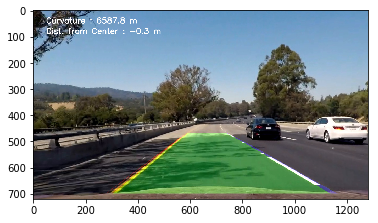

In [37]:
l_line = Line(3)
r_line = Line(3)

# 1st processing
image = mpimg.imread('./samples/39.3.jpg')
plt.imshow(process_image(image))
if l_line.detected and r_line.detected :
    print('Lane lines were detected')
else :
    print('Missed lane lines')

Missed lane lines


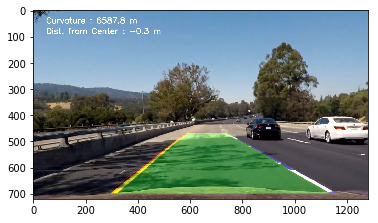

In [38]:
# 2nd (Continuous) processing
image = mpimg.imread('./samples/39.4.jpg')
plt.imshow(process_image(image))
if l_line.detected and r_line.detected :
    print('Lane lines were detected')
else :
    print('Missed lane lines')

## Processing Video

In [39]:
l_line = Line(6)
r_line = Line(6)

video_out = './result_project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
challenge_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video ./result_project_video.mp4
[MoviePy] Writing video ./result_project_video.mp4


100%|█████████▉| 1260/1261 [06:01<00:00,  3.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result_project_video.mp4 

CPU times: user 12min 49s, sys: 5.91 s, total: 12min 54s
Wall time: 6min 2s


In [40]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(video_out))